In [1]:
# ───────────────────────────────
# 📦 Standard Libraries
# ───────────────────────────────
import os
import sys
import math
import time
import csv
import pickle
from datetime import datetime, timedelta
from collections import Counter

# ───────────────────────────────
# 📚 Data Handling & Utilities
# ───────────────────────────────
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import h5py
from joblib import dump, load

# ───────────────────────────────
# 📊 Visualization
# ───────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────
# 📈 Machine Learning
# ───────────────────────────────
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_curve, roc_auc_score, auc,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# ───────────────────────────────
# 🌍 Seismology & Signal Processing
# ───────────────────────────────
import obspy
from obspy import UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.fdsn import Client
from obspy.signal.filter import envelope
from scipy import stats, signal

# ───────────────────────────────
# 🔗 External Tools
# ───────────────────────────────
from zenodo_get import zenodo_get

# ───────────────────────────────
# 🤖 Deep Learning
# ───────────────────────────────
import torch
import torch.nn.functional as F


# ───────────────────────────────
# 🛠 Custom Utilities
# ───────────────────────────────
sys.path.insert(0, '/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts')
from neural_network_architectures import SeismicCNN_2d

from utils import (
    extract_waveforms,
    compute_spectrogram,
    normalize_spectrogram_minmax,
    return_train_val_loaders,
    plot_confusion_matrix_and_cr,
    train_model,
    WaveformPreprocessor
)
from collections import defaultdict

# Pandas display options
pd.set_option('display.max_columns', None)


sys.path.append('/home/ak287/seisbench/seisbench/models')
import seisbench.models as sbm



# for extracting unique stations
import re
from pathlib import Path

cuda


## update 20 June, 2025 - Now that we have updated the model by retraining it with incorrectly classified explosions. 

In [2]:
retest_cat = pd.read_csv('../../data/curated_new_explosions_data_for_retesting.csv', index_col = 0)
event_ids = retest_cat['event_id'].values
stn_list = retest_cat['station'].values


## Computing the predictions

In [3]:
#model1 = sbm.QuakeXNetoneD.from_pretrained("base")

model1 = sbm.SeismicCNN.from_pretrained("base", version_str = '1')
model2 = sbm.SeismicCNN.from_pretrained("base", version_str = '2')
model3 = sbm.SeismicCNN.from_pretrained("base", version_str = '3')
model4 = sbm.SeismicCNN.from_pretrained("base", version_str = '4')
model5 = sbm.SeismicCNN.from_pretrained("base", version_str = '5')

## Code when checking the retrained model performance

In [4]:
len(stn_list)

3415

In [5]:
len(event_ids)

3415

## Testing all four versions of the model on this dataset. 

In [6]:
# 1️⃣  Register every model you want to run
models = {
    "m1": model1,
    "m2": model2,
    "m3": model3,
    "m4": model4,
    "m5": model5
}

# 2️⃣  Use a nested dict:  { (event, station): {model_name: probs …} }
probs_global = defaultdict(dict)

for evt_id, station in tqdm(zip(event_ids, stn_list), total=len(event_ids)):
    chn_list = glob(
        f"../../data/pnw_new_explosion_2023_2025/waveforms/{evt_id}/*{station}*"
    )

    if len(chn_list) != 3:            # skip if 3-component stream not found
        continue

    try:
        # build & sort a 3-component Stream
        st = obspy.Stream()
        for chn in chn_list:
            st += obspy.read(chn)
        st.sort(["channel"])

        # 3️⃣  run every model on the same Stream
        for name, mdl in models.items():
            probs = np.asarray(mdl.annotate(st))  # (n_windows, n_classes)
            probs_global[(evt_id, station)][name] = probs

    except Exception as e:
        print(f"[{evt_id} | {station}]  ➜  {e}")


100%|██████████| 3415/3415 [04:45<00:00, 11.95it/s]


In [7]:
CLASS_NAMES = ["eq", "px", "noise", "surface"]      # indices 0-3

def process_probabilities_wide(probs_dict, threshold=0.5):
    """
    Parameters
    ----------
    probs_dict : {(event_id, station): {model_name: np.ndarray}}
        The nested dict produced by your multi-model loop.
    threshold : float
        Confidence needed to accept a class.  Applies both to per-model
        labels and the ensemble-mean label.
    """
    rows = []

    for (event_id, station), model_dict in probs_dict.items():

        row = {"event_id": event_id, "station": station}

        # keep per-class values for later mean/max
        per_class = {cls: [] for cls in CLASS_NAMES}

        for mdl_name, probs in model_dict.items():
            # ensure shape (n_classes, n_windows)
            probs = probs if probs.shape[0] <= 4 else probs.T

            # scalar per class = max over windows
            vals = [probs[i].max() for i in range(4)]

            # per-model probability columns
            for cls, v in zip(CLASS_NAMES, vals):
                row[f"prob_{cls}_{mdl_name}"] = float(v)
                per_class[cls].append(v)

            # per-model assigned label
            eq, px, _, su = vals
            mp = max(eq, px, su)
            if mp > threshold:
                if   mp == eq: lbl = "eq"
                elif mp == px: lbl = "px"
                else:          lbl = "surface"
            else:
                lbl = "noise"

            row[f"assigned_label_{mdl_name}"] = lbl

        # ── ensemble (mean & max) ────────────────────────────────────────────
        for cls in CLASS_NAMES:
            vals = per_class[cls]
            row[f"prob_{cls}_ens_mean"] = float(np.mean(vals))
            row[f"prob_{cls}_ens_max"]  = float(np.max(vals))

        # ensemble label from mean vector
        eq_m, px_m, _, su_m = (
            row["prob_eq_ens_mean"],
            row["prob_px_ens_mean"],
            row["prob_noise_ens_mean"],
            row["prob_surface_ens_mean"],
        )
        mp = max(eq_m, px_m, su_m)
        if mp > threshold:
            row["assigned_label_ens_mean"] = (
                "eq" if mp == eq_m else "px" if mp == px_m else "surface"
            )
        else:
            row["assigned_label_ens_mean"] = "noise"

        rows.append(row)

    return pd.DataFrame(rows)


In [8]:
labels_df = process_probabilities_wide(probs_global, threshold=0.5)

In [9]:
labels_df

,event_id,station,prob_eq_m1,prob_px_m1,prob_noise_m1,prob_surface_m1,assigned_label_m1,prob_eq_m2,prob_px_m2,prob_noise_m2,prob_surface_m2,assigned_label_m2,prob_eq_m3,prob_px_m3,prob_noise_m3,prob_surface_m3,assigned_label_m3,prob_eq_m4,prob_px_m4,prob_noise_m4,prob_surface_m4,assigned_label_m4,prob_eq_m5,prob_px_m5,prob_noise_m5,prob_surface_m5,assigned_label_m5,prob_eq_ens_mean,prob_eq_ens_max,prob_px_ens_mean,prob_px_ens_max,prob_noise_ens_mean,prob_noise_ens_max,prob_surface_ens_mean,prob_surface_ens_max,assigned_label_ens_mean
0,613,AGNW,0.011282,0.314496,0.999716,0.941817,surface,0.000767,0.243819,1.000000,0.987444,surface,0.001038,0.948665,0.984931,0.998266,surface,0.001442,0.424931,0.994015,0.797836,surface,0.035721,0.380577,0.881745,0.989419,surface,0.010050,0.035721,0.462498,0.948665,0.972081,1.000000,0.942957,0.998266,surface
1,613,H2O,0.002600,0.950234,0.999696,0.706947,px,0.000671,0.775371,0.977365,0.990925,surface,0.000510,0.827166,0.835669,0.996496,surface,0.000146,0.546347,0.996186,0.788492,surface,0.001316,0.597325,0.960280,0.991933,surface,0.001049,0.002600,0.739288,0.950234,0.953839,0.999696,0.894959,0.996496,surface
2,613,PRO,0.002426,0.992798,0.997770,0.965638,px,0.001001,0.976063,0.999985,0.997437,surface,0.002034,0.978620,0.997325,0.999913,surface,0.005505,0.616747,0.991606,0.830207,surface,0.007285,0.923862,0.998963,0.990532,surface,0.003650,0.007285,0.897618,0.992798,0.997130,0.999985,0.956745,0.999913,surface
3,613,SNI2,0.012039,0.987465,0.936978,0.636058,px,0.000971,0.998962,0.997020,0.924480,px,0.025428,0.973149,0.062529,0.985683,surface,0.000658,0.996427,0.769098,0.977739,px,0.007325,0.992514,0.623878,0.999753,surface,0.009284,0.025428,0.989703,0.998962,0.677901,0.997020,0.904743,0.999753,px
4,613,YPT,0.092035,0.991765,0.999708,0.766446,px,0.040793,0.946721,1.000000,0.757288,px,0.000701,0.998053,1.000000,0.997919,px,0.001447,0.940819,1.000000,0.986835,surface,0.002261,0.978857,1.000000,0.992882,surface,0.027447,0.092035,0.971243,0.998053,0.999942,1.000000,0.900274,0.997919,px
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3410,1442,VDEB,0.014657,0.954122,0.996157,0.990612,surface,0.071950,0.883786,0.999943,0.390766,px,0.010534,0.987662,0.999471,0.999986,surface,0.002359,0.959946,0.992560,0.993291,surface,0.016050,0.914757,0.999917,0.999996,surface,0.023110,0.071950,0.940055,0.987662,0.997609,0.999943,0.874930,0.999996,px
3411,1444,COWS,0.803588,0.080832,0.997173,0.007562,eq,0.969467,0.321886,0.999998,0.012690,eq,0.987820,0.268868,0.996375,0.018458,eq,0.863459,0.474147,0.999914,0.113444,eq,0.636127,0.149287,0.999655,0.011959,eq,0.852092,0.987820,0.259004,0.474147,0.998623,0.999998,0.032822,0.113444,eq
3412,1444,FMW,0.039531,0.961076,0.988393,0.360904,px,0.763667,0.978070,0.997636,0.120847,px,0.023804,0.941046,0.668019,0.999819,surface,0.021439,0.847153,0.985323,0.986279,surface,0.167877,0.959409,0.779938,0.991980,surface,0.203264,0.763667,0.937351,0.978070,0.883862,0.997636,0.691966,0.999819,px
3413,1444,RER,0.043932,0.951239,0.979769,0.162532,px,0.012672,0.986821,0.999997,0.061548,px,0.088063,0.911139,0.999958,0.866576,px,0.144800,0.826353,0.995115,0.226330,px,0.201666,0.793958,0.999975,0.442290,px,0.098227,0.201666,0.893902,0.986821,0.994963,0.999997,0.351855,0.866576,px


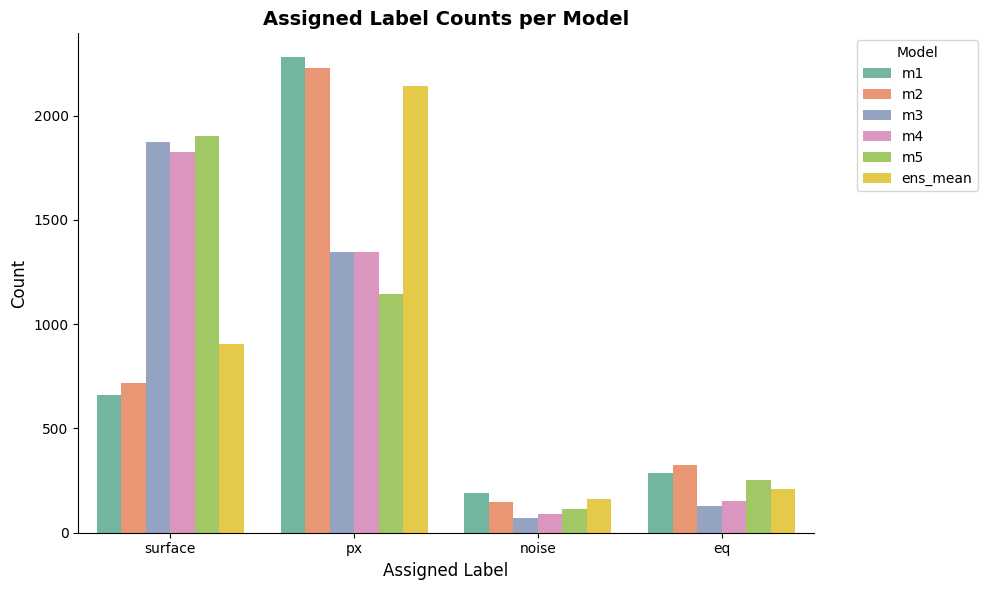

In [10]:
def plot_assigned_label_counts(labels_df, model_cols=None):
    # If not provided, auto-detect model label columns
    if model_cols is None:
        model_cols = [col for col in labels_df.columns if col.startswith("assigned_label")]

    # Convert to long-form DataFrame for Seaborn
    long_df = labels_df.melt(
        value_vars=model_cols,
        var_name="model",
        value_name="assigned_label"
    )

    # Optional: make labels cleaner (e.g., remove 'assigned_label_' prefix)
    long_df["model"] = long_df["model"].str.replace("assigned_label_", "", regex=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.countplot(data=long_df, x="assigned_label", hue="model", palette="Set2")

    plt.title("Assigned Label Counts per Model", fontsize=14, weight='bold')
    plt.xlabel("Assigned Label", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    sns.despine()
    plt.tight_layout()
    plt.show()

    
    
plot_assigned_label_counts(labels_df)

In [32]:
labels_df.to_csv('../seisbench_output/pnw_new_explosion_output_labels_from_retrained_model.csv')

In [33]:
labels_df

,event_id,station,prob_eq_m1,prob_px_m1,prob_noise_m1,prob_surface_m1,assigned_label_m1,prob_eq_m2,prob_px_m2,prob_noise_m2,prob_surface_m2,assigned_label_m2,prob_eq_m3,prob_px_m3,prob_noise_m3,prob_surface_m3,assigned_label_m3,prob_eq_m4,prob_px_m4,prob_noise_m4,prob_surface_m4,assigned_label_m4,prob_eq_ens_mean,prob_eq_ens_max,prob_px_ens_mean,prob_px_ens_max,prob_noise_ens_mean,prob_noise_ens_max,prob_surface_ens_mean,prob_surface_ens_max,assigned_label_ens_mean
0,613,AGNW,0.011282,0.314496,0.999716,0.941817,surface,0.004547,0.400763,0.995572,0.939323,surface,0.001038,0.948665,0.984931,0.998266,surface,0.001442,0.424931,0.994015,0.797836,surface,0.004577,0.011282,0.522214,0.948665,0.993559,0.999716,0.919311,0.998266,surface
1,613,H2O,0.002600,0.950234,0.999696,0.706947,px,0.016770,0.843397,0.999009,0.176436,px,0.000510,0.827166,0.835669,0.996496,surface,0.000146,0.546347,0.996186,0.788492,surface,0.005007,0.016770,0.791786,0.950234,0.957640,0.999696,0.667093,0.996496,px
2,613,PRO,0.002426,0.992798,0.997770,0.965638,px,0.217510,0.653420,0.999774,0.529716,px,0.002034,0.978620,0.997325,0.999913,surface,0.005505,0.616747,0.991606,0.830207,surface,0.056869,0.217510,0.810396,0.992798,0.996619,0.999774,0.831368,0.999913,surface
3,613,SNI2,0.012039,0.987465,0.936978,0.636058,px,0.004081,0.995465,0.996518,0.898076,px,0.025428,0.973149,0.062529,0.985683,surface,0.000658,0.996427,0.769098,0.977739,px,0.010551,0.025428,0.988126,0.996427,0.691281,0.996518,0.874389,0.985683,px
4,613,YPT,0.092035,0.991765,0.999708,0.766446,px,0.000651,0.998971,1.000000,0.978950,px,0.000701,0.998053,1.000000,0.997919,px,0.001447,0.940819,1.000000,0.986835,surface,0.023708,0.092035,0.982402,0.998971,0.999927,1.000000,0.932538,0.997919,px
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3410,1442,VDEB,0.014657,0.954122,0.996157,0.990612,surface,0.001692,0.929887,0.999935,0.555963,px,0.010534,0.987662,0.999471,0.999986,surface,0.002359,0.959946,0.992560,0.993291,surface,0.007310,0.014657,0.957904,0.987662,0.997030,0.999935,0.884963,0.999986,px
3411,1444,COWS,0.803588,0.080832,0.997173,0.007562,eq,0.685860,0.008757,0.999999,0.004483,eq,0.987820,0.268868,0.996375,0.018458,eq,0.863459,0.474147,0.999914,0.113444,eq,0.835182,0.987820,0.208151,0.474147,0.998365,0.999999,0.035987,0.113444,eq
3412,1444,FMW,0.039531,0.961076,0.988393,0.360904,px,0.244701,0.951602,1.000000,0.485754,px,0.023804,0.941046,0.668019,0.999819,surface,0.021439,0.847153,0.985323,0.986279,surface,0.082369,0.244701,0.925219,0.961076,0.910434,1.000000,0.708189,0.999819,px
3413,1444,RER,0.043932,0.951239,0.979769,0.162532,px,0.085292,0.914310,1.000000,0.102400,px,0.088063,0.911139,0.999958,0.866576,px,0.144800,0.826353,0.995115,0.226330,px,0.090522,0.144800,0.900761,0.951239,0.993710,1.000000,0.339459,0.866576,px


In [40]:
def plot_trace(tr):
    # Assuming `tr` is your ObsPy Trace object
    data = tr[0].data  # Amplitude values
    npts = tr[0].stats.npts  # Number of samples
    sampling_rate = tr[0].stats.sampling_rate  # Samples per second

    # Create time axis in seconds
    time = np.linspace(0, npts / sampling_rate, npts)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, data, linewidth=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"{tr[0].stats.station}.{tr[0].stats.channel} | {tr[0].stats.starttime}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    
snr = []
for i in tqdm(range(len(labels_df))):
    try:
        event_id = labels_df['event_id'].values[i]
        station = labels_df['station'].values[i]
        files = glob(f'../../data/pnw_new_explosion_2023_2025/waveforms/{event_id}/*{station}*HN*')
        tr = obspy.read(files[0])
        tr.resample(50)
        tr.detrend('linear')
        tr.taper(0.05)
        tr.filter('bandpass', freqmin = 1, freqmax = 20)

        #plot_trace(tr)
        #print(label)
        # snr - signal to noise ratio
        d = tr[0].data

        #snr = np.max(abs(d[3000:8000]))/np.sqrt(np.mean(abs(d[1000:2000])**(2)))
        #print(snr)

        
        snr.append(np.max(abs(d[3000:8000]))/np.sqrt(np.mean(abs(d[1000:2000])**(2))))
    except:
        snr.append(0)
    
labels_df['snr_n'] = snr

100%|██████████| 3415/3415 [00:18<00:00, 186.89it/s]


In [41]:
labels_df

,event_id,station,prob_eq_m1,prob_px_m1,prob_noise_m1,prob_surface_m1,assigned_label_m1,prob_eq_m2,prob_px_m2,prob_noise_m2,prob_surface_m2,assigned_label_m2,prob_eq_m3,prob_px_m3,prob_noise_m3,prob_surface_m3,assigned_label_m3,prob_eq_m4,prob_px_m4,prob_noise_m4,prob_surface_m4,assigned_label_m4,prob_eq_ens_mean,prob_eq_ens_max,prob_px_ens_mean,prob_px_ens_max,prob_noise_ens_mean,prob_noise_ens_max,prob_surface_ens_mean,prob_surface_ens_max,assigned_label_ens_mean,snr_n
0,613,AGNW,0.011282,0.314496,0.999716,0.941817,surface,0.004547,0.400763,0.995572,0.939323,surface,0.001038,0.948665,0.984931,0.998266,surface,0.001442,0.424931,0.994015,0.797836,surface,0.004577,0.011282,0.522214,0.948665,0.993559,0.999716,0.919311,0.998266,surface,65.960369
1,613,H2O,0.002600,0.950234,0.999696,0.706947,px,0.016770,0.843397,0.999009,0.176436,px,0.000510,0.827166,0.835669,0.996496,surface,0.000146,0.546347,0.996186,0.788492,surface,0.005007,0.016770,0.791786,0.950234,0.957640,0.999696,0.667093,0.996496,px,60.741691
2,613,PRO,0.002426,0.992798,0.997770,0.965638,px,0.217510,0.653420,0.999774,0.529716,px,0.002034,0.978620,0.997325,0.999913,surface,0.005505,0.616747,0.991606,0.830207,surface,0.056869,0.217510,0.810396,0.992798,0.996619,0.999774,0.831368,0.999913,surface,52.151577
3,613,SNI2,0.012039,0.987465,0.936978,0.636058,px,0.004081,0.995465,0.996518,0.898076,px,0.025428,0.973149,0.062529,0.985683,surface,0.000658,0.996427,0.769098,0.977739,px,0.010551,0.025428,0.988126,0.996427,0.691281,0.996518,0.874389,0.985683,px,51.560611
4,613,YPT,0.092035,0.991765,0.999708,0.766446,px,0.000651,0.998971,1.000000,0.978950,px,0.000701,0.998053,1.000000,0.997919,px,0.001447,0.940819,1.000000,0.986835,surface,0.023708,0.092035,0.982402,0.998971,0.999927,1.000000,0.932538,0.997919,px,76.740406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3410,1442,VDEB,0.014657,0.954122,0.996157,0.990612,surface,0.001692,0.929887,0.999935,0.555963,px,0.010534,0.987662,0.999471,0.999986,surface,0.002359,0.959946,0.992560,0.993291,surface,0.007310,0.014657,0.957904,0.987662,0.997030,0.999935,0.884963,0.999986,px,56.570425
3411,1444,COWS,0.803588,0.080832,0.997173,0.007562,eq,0.685860,0.008757,0.999999,0.004483,eq,0.987820,0.268868,0.996375,0.018458,eq,0.863459,0.474147,0.999914,0.113444,eq,0.835182,0.987820,0.208151,0.474147,0.998365,0.999999,0.035987,0.113444,eq,7.470058
3412,1444,FMW,0.039531,0.961076,0.988393,0.360904,px,0.244701,0.951602,1.000000,0.485754,px,0.023804,0.941046,0.668019,0.999819,surface,0.021439,0.847153,0.985323,0.986279,surface,0.082369,0.244701,0.925219,0.961076,0.910434,1.000000,0.708189,0.999819,px,48.308821
3413,1444,RER,0.043932,0.951239,0.979769,0.162532,px,0.085292,0.914310,1.000000,0.102400,px,0.088063,0.911139,0.999958,0.866576,px,0.144800,0.826353,0.995115,0.226330,px,0.090522,0.144800,0.900761,0.951239,0.993710,1.000000,0.339459,0.866576,px,24.590500


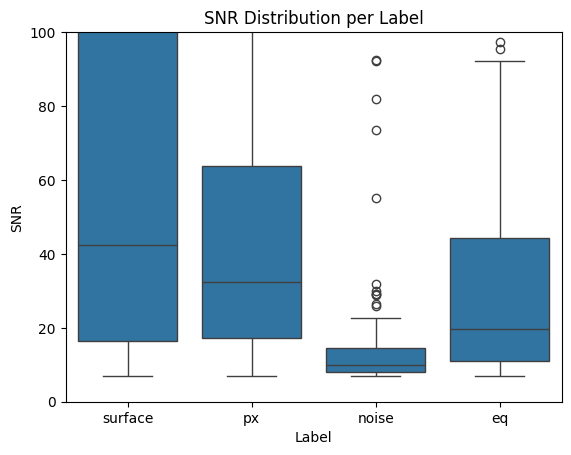

In [43]:
sns.boxplot(data=labels_df, x="assigned_label_m1", y="snr_n")
plt.title("SNR Distribution per Label")
plt.ylim(0,100)
plt.ylabel("SNR")
plt.xlabel("Label")
plt.show()


/tmp/ipykernel_3769771/2537157196.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=filtered, x='assigned_label_m2', palette='pastel', order=filtered['assigned_label_m2'].value_counts().index)


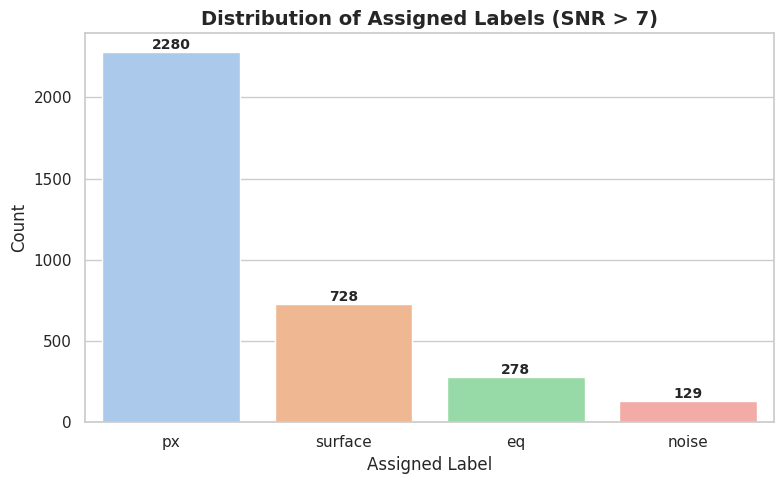

/tmp/ipykernel_3769771/2537157196.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=filtered, x='assigned_label_m3', palette='pastel', order=filtered['assigned_label_m3'].value_counts().index)


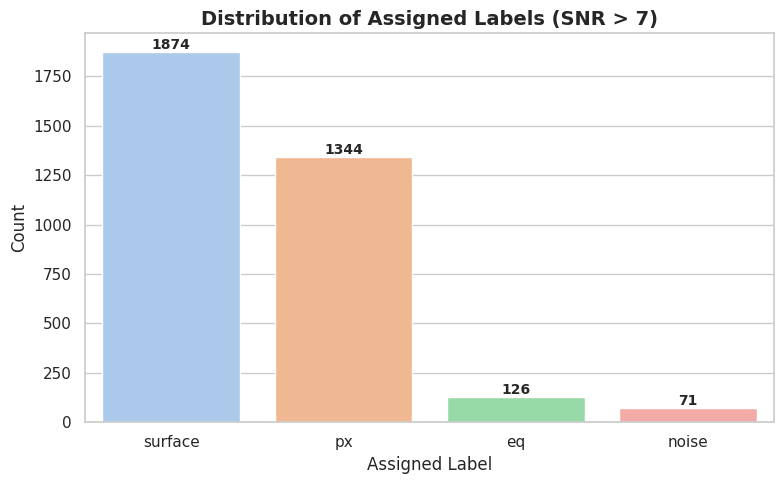

/tmp/ipykernel_3769771/2537157196.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=filtered, x='assigned_label_ens_mean', palette='pastel', order=filtered['assigned_label_ens_mean'].value_counts().index)


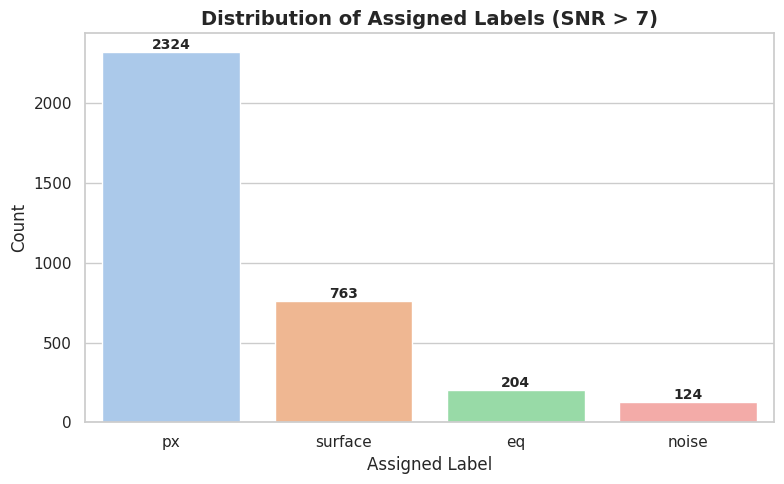

In [49]:
# Set style
sns.set(style="whitegrid")

# Filter and plot
filtered = labels_df[labels_df['snr_n'] > 7]
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=filtered, x='assigned_label_m2', palette='pastel', order=filtered['assigned_label_m2'].value_counts().index)

# Add value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Titles and labels
plt.title("Distribution of Assigned Labels (SNR > 7)", fontsize=14, weight='bold')
plt.xlabel("Assigned Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()







# Set style
sns.set(style="whitegrid")

# Filter and plot
filtered = labels_df[labels_df['snr_n'] > 7]
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=filtered, x='assigned_label_m3', palette='pastel', order=filtered['assigned_label_m3'].value_counts().index)

# Add value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Titles and labels
plt.title("Distribution of Assigned Labels (SNR > 7)", fontsize=14, weight='bold')
plt.xlabel("Assigned Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()





# Set style
sns.set(style="whitegrid")

# Filter and plot
filtered = labels_df[labels_df['snr_n'] > 7]
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=filtered, x='assigned_label_ens_mean', palette='pastel', order=filtered['assigned_label_ens_mean'].value_counts().index)

# Add value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Titles and labels
plt.title("Distribution of Assigned Labels (SNR > 7)", fontsize=14, weight='bold')
plt.xlabel("Assigned Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Event labels distribution

In [50]:
good_df  = labels_df[labels_df['snr_n'] > 7]
good_df

,event_id,station,prob_eq_m1,prob_px_m1,prob_noise_m1,prob_surface_m1,assigned_label_m1,prob_eq_m2,prob_px_m2,prob_noise_m2,prob_surface_m2,assigned_label_m2,prob_eq_m3,prob_px_m3,prob_noise_m3,prob_surface_m3,assigned_label_m3,prob_eq_m4,prob_px_m4,prob_noise_m4,prob_surface_m4,assigned_label_m4,prob_eq_ens_mean,prob_eq_ens_max,prob_px_ens_mean,prob_px_ens_max,prob_noise_ens_mean,prob_noise_ens_max,prob_surface_ens_mean,prob_surface_ens_max,assigned_label_ens_mean,snr_n
0,613,AGNW,0.011282,0.314496,0.999716,0.941817,surface,0.004547,0.400763,0.995572,0.939323,surface,0.001038,0.948665,0.984931,0.998266,surface,0.001442,0.424931,0.994015,0.797836,surface,0.004577,0.011282,0.522214,0.948665,0.993559,0.999716,0.919311,0.998266,surface,65.960369
1,613,H2O,0.002600,0.950234,0.999696,0.706947,px,0.016770,0.843397,0.999009,0.176436,px,0.000510,0.827166,0.835669,0.996496,surface,0.000146,0.546347,0.996186,0.788492,surface,0.005007,0.016770,0.791786,0.950234,0.957640,0.999696,0.667093,0.996496,px,60.741691
2,613,PRO,0.002426,0.992798,0.997770,0.965638,px,0.217510,0.653420,0.999774,0.529716,px,0.002034,0.978620,0.997325,0.999913,surface,0.005505,0.616747,0.991606,0.830207,surface,0.056869,0.217510,0.810396,0.992798,0.996619,0.999774,0.831368,0.999913,surface,52.151577
3,613,SNI2,0.012039,0.987465,0.936978,0.636058,px,0.004081,0.995465,0.996518,0.898076,px,0.025428,0.973149,0.062529,0.985683,surface,0.000658,0.996427,0.769098,0.977739,px,0.010551,0.025428,0.988126,0.996427,0.691281,0.996518,0.874389,0.985683,px,51.560611
4,613,YPT,0.092035,0.991765,0.999708,0.766446,px,0.000651,0.998971,1.000000,0.978950,px,0.000701,0.998053,1.000000,0.997919,px,0.001447,0.940819,1.000000,0.986835,surface,0.023708,0.092035,0.982402,0.998971,0.999927,1.000000,0.932538,0.997919,px,76.740406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3410,1442,VDEB,0.014657,0.954122,0.996157,0.990612,surface,0.001692,0.929887,0.999935,0.555963,px,0.010534,0.987662,0.999471,0.999986,surface,0.002359,0.959946,0.992560,0.993291,surface,0.007310,0.014657,0.957904,0.987662,0.997030,0.999935,0.884963,0.999986,px,56.570425
3411,1444,COWS,0.803588,0.080832,0.997173,0.007562,eq,0.685860,0.008757,0.999999,0.004483,eq,0.987820,0.268868,0.996375,0.018458,eq,0.863459,0.474147,0.999914,0.113444,eq,0.835182,0.987820,0.208151,0.474147,0.998365,0.999999,0.035987,0.113444,eq,7.470058
3412,1444,FMW,0.039531,0.961076,0.988393,0.360904,px,0.244701,0.951602,1.000000,0.485754,px,0.023804,0.941046,0.668019,0.999819,surface,0.021439,0.847153,0.985323,0.986279,surface,0.082369,0.244701,0.925219,0.961076,0.910434,1.000000,0.708189,0.999819,px,48.308821
3413,1444,RER,0.043932,0.951239,0.979769,0.162532,px,0.085292,0.914310,1.000000,0.102400,px,0.088063,0.911139,0.999958,0.866576,px,0.144800,0.826353,0.995115,0.226330,px,0.090522,0.144800,0.900761,0.951239,0.993710,1.000000,0.339459,0.866576,px,24.590500


In [51]:
import pandas as pd
import numpy as np

CLASS_NAMES  = ["eq", "px", "noise", "surface"]
MODEL_NAMES  = ["m1", "m2", "m3", "m4"]           # adjust if you add/remove models
THRESHOLD    = 0.5                                # confidence cut-off

def event_labels_from_stations(df):
    """
    Parameters
    ----------
    df : DataFrame
        Your `good_df` with one row per (event_id, station).
    Returns
    -------
    event_df : DataFrame
        One row per event_id with mean probs and assigned labels.
    """

    # --- 1. Average probs across stations ----------------------------------
    prob_cols = []
    for m in MODEL_NAMES:
        for cls in CLASS_NAMES:
            prob_cols.append(f"prob_{cls}_{m}")
    for cls in CLASS_NAMES:                       # ensemble columns
        prob_cols.extend([f"prob_{cls}_ens_mean", f"prob_{cls}_ens_max"])

    mean_df = (
        df[["event_id"] + prob_cols]
        .groupby("event_id", as_index=False)
        .mean()
    )

    # --- 2. Assign labels per model ----------------------------------------
    for m in MODEL_NAMES:
        eq, px, nz, su = (
            mean_df[f"prob_eq_{m}"],
            mean_df[f"prob_px_{m}"],
            mean_df[f"prob_noise_{m}"],
            mean_df[f"prob_surface_{m}"],
        )
        vmax = pd.concat([eq, px, su], axis=1).max(axis=1)   # ignore noise for winner
        lbl  = np.where(
            vmax <= THRESHOLD, "noise",
            np.select(
                [vmax.eq(eq), vmax.eq(px)],
                ["eq",      "px"],
                default="surface"
            )
        )
        mean_df[f"event_label_{m}"] = lbl

    # --- 3. Assign label for ensemble-mean ---------------------------------
    eq_m, px_m, nz_m, su_m = (
        mean_df["prob_eq_ens_mean"],
        mean_df["prob_px_ens_mean"],
        mean_df["prob_noise_ens_mean"],
        mean_df["prob_surface_ens_mean"],
    )
    vmax = pd.concat([eq_m, px_m, su_m], axis=1).max(axis=1)
    lbl  = np.where(
        vmax <= THRESHOLD, "noise",
        np.select(
            [vmax.eq(eq_m), vmax.eq(px_m)],
            ["eq",         "px"],
            default="surface"
        )
    )
    mean_df["event_label_ens_mean"] = lbl

    return mean_df


In [52]:
event_df = event_labels_from_stations(good_df)

# quick peek
event_df.head()


,event_id,prob_eq_m1,prob_px_m1,prob_noise_m1,prob_surface_m1,prob_eq_m2,prob_px_m2,prob_noise_m2,prob_surface_m2,prob_eq_m3,prob_px_m3,prob_noise_m3,prob_surface_m3,prob_eq_m4,prob_px_m4,prob_noise_m4,prob_surface_m4,prob_eq_ens_mean,prob_eq_ens_max,prob_px_ens_mean,prob_px_ens_max,prob_noise_ens_mean,prob_noise_ens_max,prob_surface_ens_mean,prob_surface_ens_max,event_label_m1,event_label_m2,event_label_m3,event_label_m4,event_label_ens_mean
0,613,0.024076,0.847351,0.986774,0.803381,0.048712,0.778403,0.998175,0.704500,0.005942,0.945130,0.776091,0.995655,0.001840,0.705054,0.950181,0.876222,0.020142,0.072605,0.818985,0.977419,0.927805,0.999141,0.844940,0.995655,px,px,surface,surface,surface
1,614,0.148150,0.769720,0.615363,0.974034,0.017848,0.930895,0.982537,0.777597,0.213882,0.960009,0.422657,0.931832,0.079969,0.809857,0.899246,0.767145,0.114962,0.229941,0.867620,0.960009,0.729951,0.982537,0.862652,0.999091,surface,px,px,px,px
2,615,0.026851,0.596614,0.984743,0.273578,0.215759,0.057666,0.998839,0.650156,0.009185,0.644793,0.982741,0.926790,0.004001,0.069694,0.999884,0.993699,0.063949,0.215759,0.342192,0.644793,0.991552,0.999884,0.711056,0.993699,px,surface,surface,surface,surface
3,616,0.028424,0.759468,0.983816,0.450114,0.047508,0.714408,0.999697,0.535295,0.004283,0.870799,0.948111,0.830216,0.003850,0.796581,0.915717,0.585368,0.021016,0.062448,0.785314,0.954450,0.961835,0.999751,0.600248,0.857943,px,px,px,px,px
4,617,0.042313,0.978137,0.992276,0.474670,0.005938,0.900634,0.994378,0.443611,0.290484,0.985480,0.888385,0.999844,0.004554,0.883511,0.986186,0.998534,0.085823,0.315241,0.936941,0.993138,0.965306,0.998698,0.729165,0.999844,px,px,surface,surface,px


/tmp/ipykernel_3769771/686271262.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data= event_df, x='event_label_m1', palette='Set2')


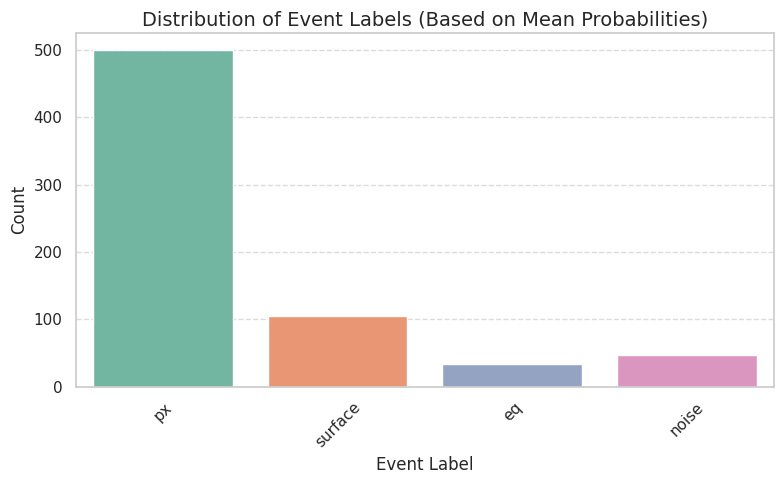

/tmp/ipykernel_3769771/686271262.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data= event_df, x='event_label_m2', palette='Set2')


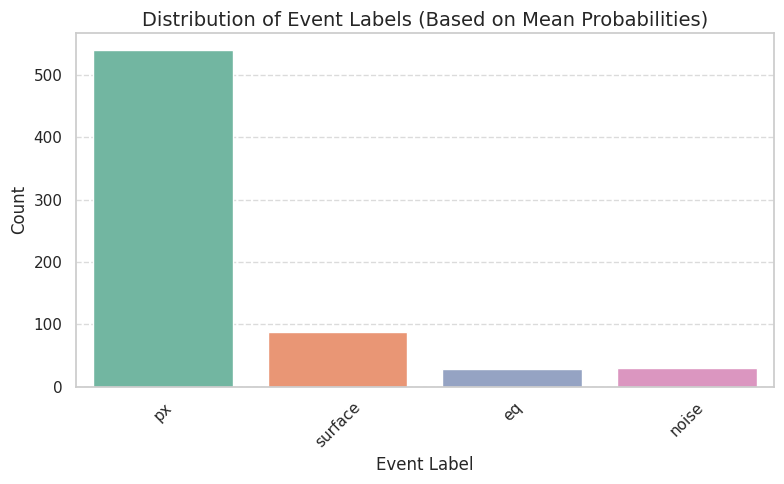

/tmp/ipykernel_3769771/686271262.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data= event_df, x='event_label_m3', palette='Set2')


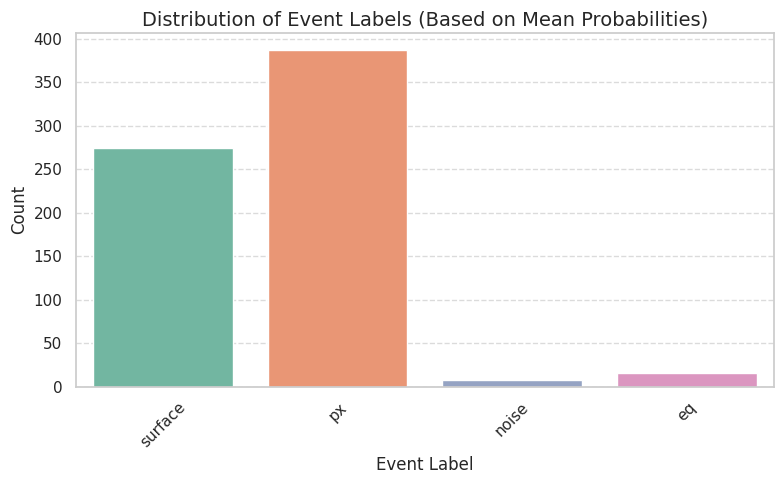

/tmp/ipykernel_3769771/686271262.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data= event_df, x='event_label_m4', palette='Set2')


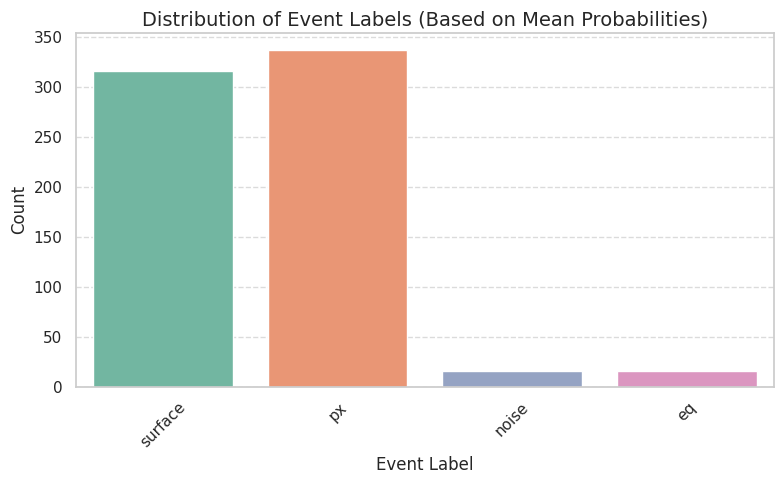

/tmp/ipykernel_3769771/686271262.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data= event_df, x='event_label_ens_mean', palette='Set2')


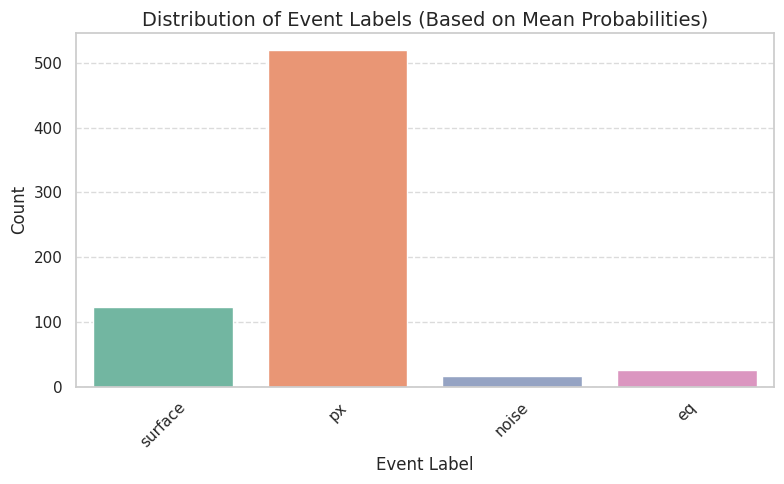

In [59]:
plt.figure(figsize=(8, 5))
sns.countplot(data= event_df, x='event_label_m1', palette='Set2')

plt.title('Distribution of Event Labels (Based on Mean Probabilities)', fontsize=14)
plt.xlabel('Event Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()





plt.figure(figsize=(8, 5))
sns.countplot(data= event_df, x='event_label_m2', palette='Set2')

plt.title('Distribution of Event Labels (Based on Mean Probabilities)', fontsize=14)
plt.xlabel('Event Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




plt.figure(figsize=(8, 5))
sns.countplot(data= event_df, x='event_label_m3', palette='Set2')

plt.title('Distribution of Event Labels (Based on Mean Probabilities)', fontsize=14)
plt.xlabel('Event Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



plt.figure(figsize=(8, 5))
sns.countplot(data= event_df, x='event_label_m4', palette='Set2')

plt.title('Distribution of Event Labels (Based on Mean Probabilities)', fontsize=14)
plt.xlabel('Event Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()





plt.figure(figsize=(8, 5))
sns.countplot(data= event_df, x='event_label_ens_mean', palette='Set2')

plt.title('Distribution of Event Labels (Based on Mean Probabilities)', fontsize=14)
plt.xlabel('Event Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [58]:
event_df

,event_id,prob_eq_m1,prob_px_m1,prob_noise_m1,prob_surface_m1,prob_eq_m2,prob_px_m2,prob_noise_m2,prob_surface_m2,prob_eq_m3,prob_px_m3,prob_noise_m3,prob_surface_m3,prob_eq_m4,prob_px_m4,prob_noise_m4,prob_surface_m4,prob_eq_ens_mean,prob_eq_ens_max,prob_px_ens_mean,prob_px_ens_max,prob_noise_ens_mean,prob_noise_ens_max,prob_surface_ens_mean,prob_surface_ens_max,event_label_m1,event_label_m2,event_label_m3,event_label_m4,event_label_ens_mean
0,613,0.024076,0.847351,0.986774,0.803381,0.048712,0.778403,0.998175,0.704500,0.005942,0.945130,0.776091,0.995655,0.001840,0.705054,0.950181,0.876222,0.020142,0.072605,0.818985,0.977419,0.927805,0.999141,0.844940,0.995655,px,px,surface,surface,surface
1,614,0.148150,0.769720,0.615363,0.974034,0.017848,0.930895,0.982537,0.777597,0.213882,0.960009,0.422657,0.931832,0.079969,0.809857,0.899246,0.767145,0.114962,0.229941,0.867620,0.960009,0.729951,0.982537,0.862652,0.999091,surface,px,px,px,px
2,615,0.026851,0.596614,0.984743,0.273578,0.215759,0.057666,0.998839,0.650156,0.009185,0.644793,0.982741,0.926790,0.004001,0.069694,0.999884,0.993699,0.063949,0.215759,0.342192,0.644793,0.991552,0.999884,0.711056,0.993699,px,surface,surface,surface,surface
3,616,0.028424,0.759468,0.983816,0.450114,0.047508,0.714408,0.999697,0.535295,0.004283,0.870799,0.948111,0.830216,0.003850,0.796581,0.915717,0.585368,0.021016,0.062448,0.785314,0.954450,0.961835,0.999751,0.600248,0.857943,px,px,px,px,px
4,617,0.042313,0.978137,0.992276,0.474670,0.005938,0.900634,0.994378,0.443611,0.290484,0.985480,0.888385,0.999844,0.004554,0.883511,0.986186,0.998534,0.085823,0.315241,0.936941,0.993138,0.965306,0.998698,0.729165,0.999844,px,px,surface,surface,px
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,1440,0.491597,0.278768,0.977865,0.519800,0.262519,0.562627,0.995383,0.343672,0.158159,0.906858,0.932013,0.254067,0.195759,0.618892,0.994984,0.301943,0.277009,0.599537,0.591786,0.906858,0.975061,0.995446,0.354870,0.686892,surface,px,px,px,px
681,1441,0.106579,0.843814,0.992363,0.289329,0.031175,0.781606,0.999781,0.255410,0.008000,0.901102,0.868468,0.820842,0.015405,0.849017,0.979887,0.608784,0.040290,0.114448,0.843885,0.922158,0.960125,0.999829,0.493591,0.826321,px,px,px,px,px
682,1442,0.074378,0.969888,0.971612,0.602638,0.012860,0.952878,0.999967,0.278874,0.015131,0.993550,0.872013,0.892805,0.001505,0.974103,0.993386,0.842639,0.025969,0.074378,0.972605,0.993550,0.959245,0.999967,0.654239,0.892805,px,px,px,px,px
683,1444,0.295684,0.664383,0.988445,0.176999,0.338617,0.624890,1.000000,0.197546,0.366562,0.707018,0.888117,0.628284,0.343233,0.715884,0.993451,0.442018,0.336024,0.459107,0.678044,0.795487,0.967503,1.000000,0.361212,0.659947,px,px,px,px,px


In [23]:
good_df  = labels_df[labels_df['snr_n'] > 7]
mean_probs = good_df.groupby('event_id')[['prob_eq', 'prob_px', 'prob_surface']].mean()

# Step 2: Identify the label with the highest mean probability (excluding noise)
mean_probs['event_label'] = mean_probs.idxmax(axis=1).str.replace('prob_', '')

# Optional: merge back into original DataFrame if needed
good_df = good_df.merge(mean_probs['event_label'], on='event_id', how='left')

/tmp/ipykernel_2875840/1556354953.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=mean_probs, x='event_label', palette='Set2')


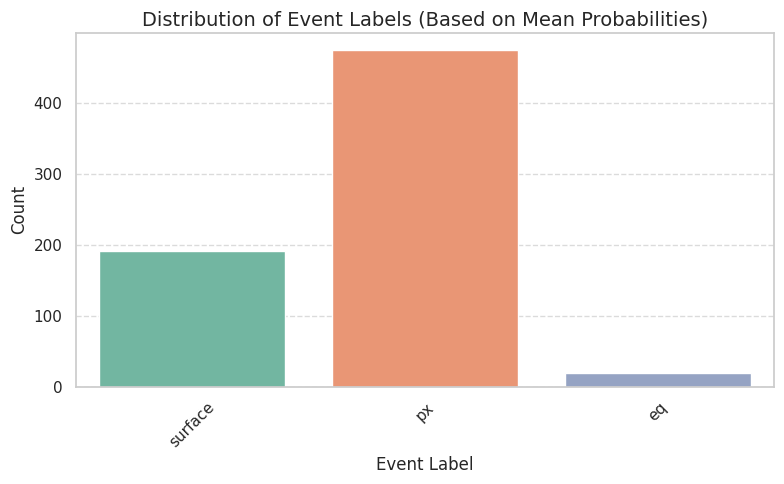

In [24]:
plt.figure(figsize=(8, 5))
sns.countplot(data=mean_probs, x='event_label', palette='Set2')

plt.title('Distribution of Event Labels (Based on Mean Probabilities)', fontsize=14)
plt.xlabel('Event Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [49]:
def plot_event_waveforms(event_id, labels_df, savepath = '../seisbench_output/pnw_new_classification_figures/earthquake/'):
    # Filter rows for this event
    subset = labels_df[labels_df['event_id'] == event_id]

    if subset.empty:
        print(f"No data found for event {event_id}")
        return
    
    # Get event-level label from the first row
    event_label = subset['event_label'].iloc[0]
    
    fig, ax = plt.subplots(figsize=(12, 1.8 * len(subset)))
    
    for idx, row in subset.iterrows():
        station = row['station']
        
        # Find the vertical-component HZ file
        files = glob(f'../../data/pnw_new_explosion_2023_2025/waveforms/{event_id}/*{station}*HZ*')
        if not files:
            print(f"No HZ component found for {station} in event {event_id}")
            continue
        
        try:
            tr = obspy.read(files[0])[0]
            tr.resample(50)
            tr.detrend('linear')
            tr.taper(0.05)
            tr.filter('bandpass', freqmin=1, freqmax=20)
            data = tr.data
            times = np.arange(len(data)) / tr.stats.sampling_rate

            # Offset the waveform vertically
            offset = idx
            ax.plot(times, data / np.max(np.abs(data)) + offset, lw=0.8, color='steelblue')

            # Format the label with probabilities
            prob_text = f"{station} | eq:{row['prob_eq']:.2f} px:{row['prob_px']:.2f} su:{row['prob_surface']:.2f}"
            ax.text(times[-1] + 2, offset, prob_text, va='center', fontsize=8)

        except Exception as e:
            print(f"Error loading {station} for event {event_id}: {e}")
            continue
    
    ax.set_title(f"Event {event_id} | Label: {event_label.upper()}", fontsize=14, weight='bold')
    ax.set_xlabel("Time (s)")
    ax.set_yticks([])  # Remove numerical ticks; we use text annotations
    ax.set_ylabel("Stations (vertical offset)")
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    # Ensure save directory exists
    os.makedirs(savepath, exist_ok=True)
    # Now save
    plt.savefig(os.path.join(savepath, f'{event_id}_from_retrained.png'))
    
    plt.close()

In [50]:
eq_df = mean_probs[mean_probs['event_label'] == 'eq']
px_df = mean_probs[mean_probs['event_label'] == 'px']
su_df = mean_probs[mean_probs['event_label'] == 'surface']

In [51]:
event_ids = eq_df.index.values
for evid in event_ids:
    plot_event_waveforms(event_id= evid, labels_df= good_df, savepath = '../seisbench_output/pnw_new_classification_figures/earthquake/')

    
event_ids = px_df.index.values
for evid in event_ids:
    plot_event_waveforms(event_id= evid, labels_df= good_df, savepath = '../seisbench_output/pnw_new_classification_figures/explosion/')

    
event_ids = su_df.index.values
for evid in event_ids:
    plot_event_waveforms(event_id= evid, labels_df= good_df, savepath = '../seisbench_output/pnw_new_classification_figures/surface/')

## Selecting near field explosions for retraining

### Ok it seems like near field explosion events are getting confused with surface events. We are going to select all the explosions that were labelled as surface events or earthquakes and retrain the model by including these additional explosion events, we will held out a test dataset for the purpose of further testing. 

In [55]:
retrain_df = good_df[good_df['assigned_label'] != 'px']

In [69]:
retrain_ids = np.unique(retrain_df['event_id'])[0:500]
final_retrain_df = retrain_df[retrain_df['event_id'].isin(retrain_ids)]
final_retest_df = retrain_df[~retrain_df['event_id'].isin(retrain_ids)]

In [70]:
final_retest_df

,event_id,station,prob_eq,prob_px,prob_noise,prob_surface,max_prob,assigned_label,snr_n,event_label
3634,613,AGNW,0.007429,0.145115,0.625048,0.999631,0.999631,surface,65.960369,surface
3636,613,H2O,0.025686,0.707756,0.825063,0.999868,0.999868,surface,60.741691,surface
3637,613,PRO,0.029811,0.374436,0.992602,0.999868,0.999868,surface,52.151577,surface
3638,613,SNI2,0.042300,0.956482,0.611664,0.999122,0.999122,surface,51.560611,surface
3639,613,YPT,0.005421,0.855344,0.999999,0.998845,0.998845,surface,76.740406,surface
...,...,...,...,...,...,...,...,...,...,...
8382,1442,VDEB,0.029686,0.929208,0.995216,0.999971,0.999971,surface,56.570425,surface
8383,1444,COWS,0.554897,0.483584,0.997621,0.238631,0.554897,eq,7.470058,surface
8384,1444,FMW,0.247488,0.779325,0.774267,0.999721,0.999721,surface,48.308821,surface
8385,1444,RER,0.132664,0.845789,0.999380,0.946960,0.946960,surface,24.590500,surface


In [73]:
final_retrain_df.to_csv('../../data/curated_new_explosions_data_for_retraining.csv')
final_retest_df.to_csv('../../data/curated_new_explosions_data_for_retesting.csv')